In [11]:
import pandas as pd
from sklearn.metrics import roc_curve, roc_auc_score, classification_report
SEED=2020

# Загрузка данных
file_path = 'all_data-6-10.csv'  # Название файла
data = pd.read_csv(file_path)
# data = data.sample(n=50000, random_state=SEED)


# Определение целевой переменной
target_column = '168' 
class_balance = data[target_column].value_counts(normalize=True)
print("\nДисбаланс классов:")
print(class_balance)


Дисбаланс классов:
168
0.0    0.502724
1.0    0.497276
Name: proportion, dtype: float64


In [15]:
selected_features = ['2', '7', '39', '89', '96', '99', '131', '161', '165', '166','168'] # список получен после рекурсивного удаления признаков 
df = data[selected_features] # отфильтрованный датасет
target_column = '168' #целевой признак
X = df.drop(columns=[target_column]) # разделение датасета на X/y
y = df[target_column]



[I 2024-12-26 12:05:09,286] A new study created in memory with name: no-name-955ed68f-cd75-4423-8870-0562423a384d
[I 2024-12-26 12:11:45,651] Trial 0 finished with value: 0.8793071678643818 and parameters: {'learning_rate': 0.21860421428868368, 'n_estimators': 265, 'max_depth': 10, 'min_child_weight': 5, 'gamma': 4.426552671106066, 'colsample_bytree': 0.9437934417524487}. Best is trial 0 with value: 0.8793071678643818.
[I 2024-12-26 12:19:32,991] Trial 1 finished with value: 0.9062957540263543 and parameters: {'learning_rate': 0.07675190595764436, 'n_estimators': 493, 'max_depth': 9, 'min_child_weight': 9, 'gamma': 3.945788369895054, 'colsample_bytree': 0.6691257451986223}. Best is trial 1 with value: 0.9062957540263543.
[I 2024-12-26 12:25:26,258] Trial 2 finished with value: 0.9275225011842728 and parameters: {'learning_rate': 0.015501024025899202, 'n_estimators': 376, 'max_depth': 8, 'min_child_weight': 7, 'gamma': 2.8521338088738495, 'colsample_bytree': 0.7340295931173382}. Best is

Лучшие параметры: {'learning_rate': 0.01039279303964284, 'n_estimators': 248, 'max_depth': 8, 'min_child_weight': 1, 'gamma': 3.006453143664094, 'colsample_bytree': 0.7987796924669794}
   Threshold  Precision  True Positives  False Positives  False Positive Rate
0       0.70   0.854982            4127              700             0.005018
1       0.75   0.902938            2428              261             0.001871
2       0.80   0.953966            1347               65             0.000466
3       0.85   0.965732             620               22             0.000158
4       0.90   0.983471             119                2             0.000014


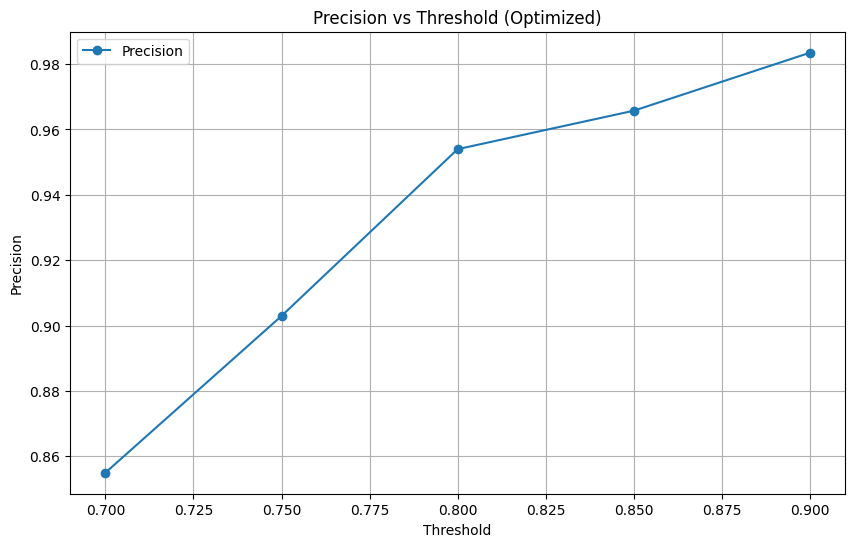

In [16]:
import numpy as np
import optuna
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import precision_score
import matplotlib.pyplot as plt

# Оптимизационная функция для Optuna
def objective(trial):
    # Подбор гиперпараметров
    learning_rate = trial.suggest_float("learning_rate", 0.01, 0.3)
    n_estimators = trial.suggest_int("n_estimators", 100, 500)
    max_depth = trial.suggest_int("max_depth", 3, 10)
    min_child_weight = trial.suggest_int("min_child_weight", 1, 10)
    gamma = trial.suggest_float("gamma", 0, 5)
    colsample_bytree = trial.suggest_float("colsample_bytree", 0.5, 1.0)

    # Определение модели
    model = XGBClassifier(
        eval_metric='logloss',
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_child_weight=min_child_weight,
        gamma=gamma,
        colsample_bytree=colsample_bytree,
        random_state=42
    )

    # Кросс-валидация
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    y_pred_proba = cross_val_predict(model, X, y, cv=cv, method='predict_proba')[:, 1]

    # Трешхолд анализа
    threshold = 0.8
    y_pred = (y_pred_proba >= threshold).astype(int)
    precision = precision_score(y, y_pred)
    return precision

# Оптимизация с помощью Optuna
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)
print("Лучшие параметры:", study.best_params)

# Применение лучших параметров
best_params = study.best_params
best_model = XGBClassifier(
    eval_metric='logloss',
    learning_rate=best_params["learning_rate"],
    n_estimators=best_params["n_estimators"],
    max_depth=best_params["max_depth"],
    min_child_weight=best_params["min_child_weight"],
    gamma=best_params["gamma"],
    colsample_bytree=best_params["colsample_bytree"],
    random_state=42
)

# Оценка модели с лучшими параметрами
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
y_pred_proba = cross_val_predict(best_model, X, y, cv=cv, method='predict_proba')[:, 1]

# Анализ precision на разных трешхолдах
thresholds = np.linspace(0.7, 0.9, 5)
results = []
for threshold in thresholds:
    y_pred = (y_pred_proba >= threshold).astype(int)
    precision = precision_score(y, y_pred)
    tp = np.sum((y_pred == 1) & (y == 1))
    fp = np.sum((y_pred == 1) & (y == 0))
    results.append({
        "Threshold": threshold,
        "Precision": precision,
        "True Positives": tp,
        "False Positives": fp,
        "False Positive Rate": fp / len(y_pred)
    })

# Создаём DataFrame для результатов
results_df = pd.DataFrame(results)
print(results_df)

# Визуализация Precision vs Threshold
plt.figure(figsize=(10, 6))
plt.plot(results_df["Threshold"], results_df["Precision"], marker='o', label='Precision')
plt.xlabel("Threshold")
plt.ylabel("Precision")
plt.title("Precision vs Threshold (Optimized)")
plt.grid()
plt.legend()
plt.show()
